Missing values in dataset: 2
Epoch 1/2000


C:\Users\yuta\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan - val_loss: nan
Epoch 2/2000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 3/2000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 4/2000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 5/2000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 6/2000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 7/2000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 8/2000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 9/2000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 10/2000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan


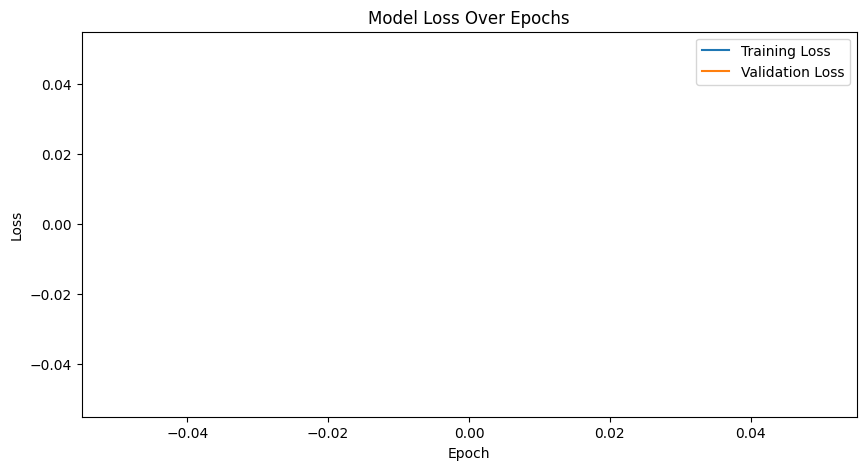

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step


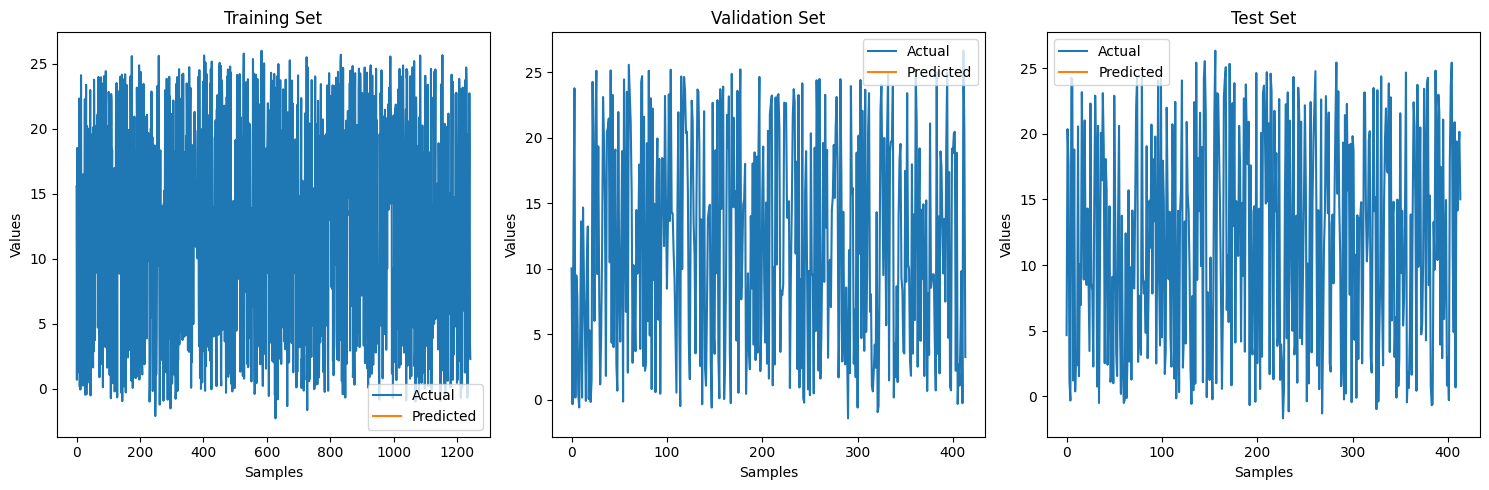

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = "JapanLandTemperature.csv"  # Adjust the file path if needed
df = pd.read_csv(file_path)

# Use only the 'World' column
df['dt'] = pd.to_datetime(df['dt'])
df.set_index('dt', inplace=True)
sequence = df['AverageTemperature'].values

# Check for missing values
print("Missing values in dataset:", df.isnull().sum().sum())

# Function to split the sequence into samples
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence) - n_steps):
        seq_x, seq_y = sequence[i:i + n_steps], sequence[i + n_steps]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Define the number of time steps
n_steps = 3

# Split the data into samples
X, y = split_sequence(sequence, n_steps)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)   # 60% training, 40% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% validation, 20% test

# Reshape the data for the CNN model
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_val_scaled = scaler_X.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Set the seed for reproducibility
np.random.seed(100)
tf.random.set_seed(100)

# Define the Sequential model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train_scaled, epochs=2000, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), callbacks=[early_stopping], verbose=1)

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Predict and plot
y_train_pred_scaled = model.predict(X_train_scaled)
y_val_pred_scaled = model.predict(X_val_scaled)
y_test_pred_scaled = model.predict(X_test_scaled)

# Inverse transform the predictions to the original scale
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

# Plotting
plt.figure(figsize=(15, 5))

# Training set
plt.subplot(1, 3, 1)
plt.plot(y_train, label='Actual')
plt.plot(y_train_pred, label='Predicted')
plt.title('Training Set')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

# Validation set
plt.subplot(1, 3, 2)
plt.plot(y_val, label='Actual')
plt.plot(y_val_pred, label='Predicted')
plt.title('Validation Set')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

# Test set
plt.subplot(1, 3, 3)
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title('Test Set')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()




In [3]:
df

,AverageTemperature,AverageTemperatureUncertainty,Country
dt,,,
1841-01-01,-1.100,2.228,Japan
1841-02-01,-0.079,1.836,Japan
1841-03-01,2.680,2.221,Japan
1841-04-01,8.400,2.067,Japan
1841-05-01,13.796,1.759,Japan
...,...,...,...
2013-05-01,15.256,0.235,Japan
2013-06-01,19.961,0.380,Japan
2013-07-01,24.286,0.369,Japan
